In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.utils import shuffle

from tools import plot_confusion_matrix

In [2]:
df = pd.read_csv('../data/datatran_2016-2017.csv')
df.shape

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(184224, 32)

In [3]:
df.head()

,br,causa_acidente,classificacao_acidente,condicao_metereologica,delegacia,dia_semana,fase_dia,feridos,feridos_graves,feridos_leves,...,tracado_via,uf,uop,uso_solo,veiculos,hora,ano,mes,dia,target
0,376.0,Fenômenos da Natureza ...,Com Vítimas Feridas,Chuva,DEL7/7,domingo,Plena Noite,1,1,0,...,Reta,PR,UOP05/PR,Não,1,0,2017,1,1,1
1,101.0,Falta de Atenção à Condução ...,Sem Vítimas,Chuva,DEL8/1,domingo,Plena Noite,0,0,0,...,Curva,SC,UOP02/SC,Não,1,0,2017,1,1,0
2,153.0,Animais na Pista ...,Com Vítimas Feridas,Garoa/Chuvisco,DEL7/7,domingo,Plena Noite,2,0,2,...,Reta,PR,UOP07/PR,Não,1,0,2017,1,1,1
3,153.0,Avarias e/ou desgaste excessivo no pneu ...,Com Vítimas Feridas,Céu Claro,DEL1/2,domingo,Plena Noite,1,1,0,...,Reta,GO,UOP01/GO,Sim,1,0,2017,1,1,1
4,280.0,Ingestão de Álcool ...,Com Vítimas Feridas,Chuva,DEL8/6,domingo,Plena Noite,1,0,1,...,Não Informado,SC,UOP03/SC,Não,1,0,2017,1,1,1


In [4]:
df.columns

Index(['br', 'causa_acidente', 'classificacao_acidente',
       'condicao_metereologica', 'delegacia', 'dia_semana', 'fase_dia',
       'feridos', 'feridos_graves', 'feridos_leves', 'ignorados', 'ilesos',
       'km', 'latitude', 'longitude', 'mortos', 'municipio', 'pessoas',
       'regional', 'sentido_via', 'tipo_acidente', 'tipo_pista', 'tracado_via',
       'uf', 'uop', 'uso_solo', 'veiculos', 'hora', 'ano', 'mes', 'dia',
       'target'],
      dtype='object')

In [5]:
df.target.value_counts()

1    108520
0     65167
2     10537
Name: target, dtype: int64

In [6]:
65167-10537

54630

In [7]:
class0 = df[df.target==0]
class1 = df[df.target==1].sample(54630)
class2 = df[df.target==2]


In [8]:
class0.target = 1
class1.target = 0
class2.target = 0 

df2 = shuffle(pd.concat([class0, class1, class2]))

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
dd = df2[['dia_semana', 'br', 'km', 'regional', 'causa_acidente', 
        'fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'target']]
dd.dropna(inplace=True)

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
X = pd.get_dummies(dd.drop(['target'], axis=1))
y = dd['target']

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_PCA = pca.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

In [13]:
model = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1., 1.5],
    'class_weight': ['balanced', None]
}


scorer = make_scorer(score_func=accuracy_score)

grid_obj = GridSearchCV(model, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

In [14]:
best_clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
joblib.dump(best_clf, '../model/model_v10-no-victms.pkl')

['../model/model_v10-no-victms.pkl']

In [16]:
y_pred = best_clf.predict(X_test)

Confusion matrix, without normalization
[[4123 2233]
 [2763 3429]]


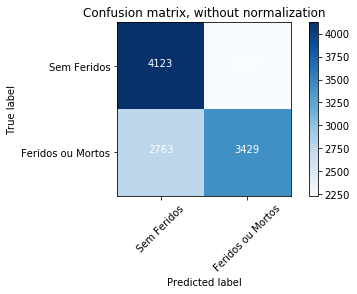

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Sem Feridos', 'Feridos ou Mortos'],
                      title='Confusion matrix, without normalization')

In [18]:
accuracy_score(y_test, y_pred)

0.6018489002231431

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.60      0.65      0.62      6356
          1       0.61      0.55      0.58      6192

avg / total       0.60      0.60      0.60     12548



In [20]:
y_pred_proba = best_clf.predict_proba(X_test)
y_pred_proba

array([[0.47799661, 0.52200339],
       [0.51025078, 0.48974922],
       [0.46578454, 0.53421546],
       ...,
       [0.55708413, 0.44291587],
       [0.46459788, 0.53540212],
       [0.40061841, 0.59938159]])